## 1. Read the data

In [434]:
# Read the data 
import pandas as pd
data_df = pd.read_csv('data/insurance.csv')
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Data cleaning

In [435]:
# Check for missing values
data_df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Luckily we have no missing data, proceeding to look at distribution of numerical and categorical features

In [436]:
# check for distribution of numerical features
data_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [437]:
# get summary of categorical features
data_df.describe(include=['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


The data looks skewed towards non-smokers over smokers.  Proceeding to look at the correlation matrix.

## 3. Plotting, scaling, normalizing

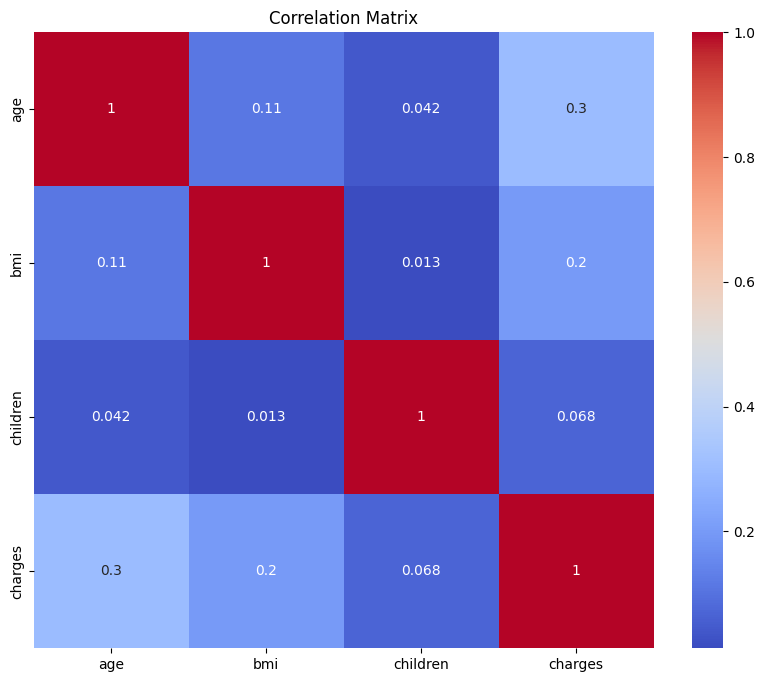

In [438]:
# plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# only numerical features are considered for correlation
numerical_features = data_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

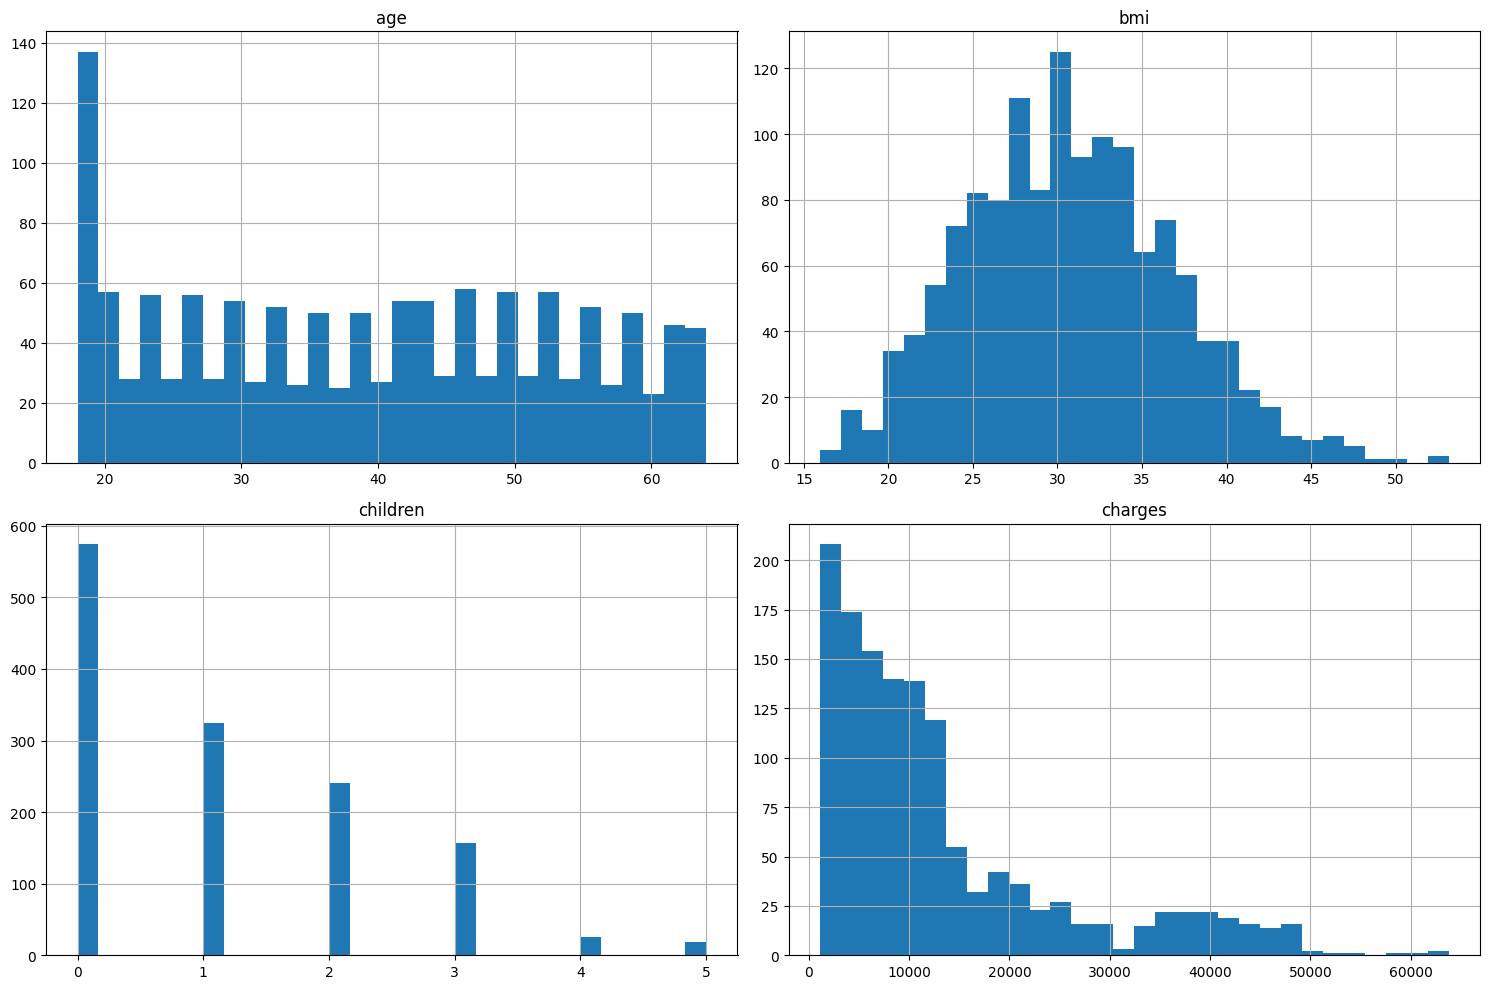

In [439]:
# plot a grid of histograms of charges and the other features to see their distributions
data_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

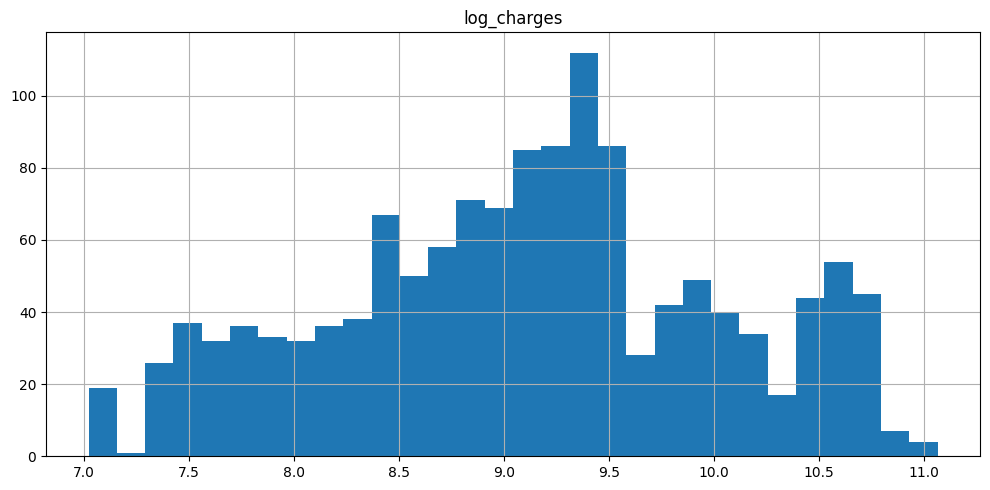

In [440]:
# Since age and charges are right skewed, we can apply log transformation to them
#data_df['log_age'] = np.log(data_df['age'])
data_df['log_charges'] = np.log(data_df['charges'])
data_df[['log_charges']].hist(bins=30, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [441]:
# Drop the original charges column
data_df = data_df.drop(columns=['charges'])

In [442]:
# normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = ['age', 'bmi', 'children']
data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])
data_df.head()

,age,sex,bmi,children,smoker,region,log_charges
0,-1.438764,female,-0.453320,-0.908614,yes,southwest,9.734176
1,-1.509965,male,0.509621,-0.078767,no,southeast,7.453302
2,-0.797954,male,0.383307,1.580926,no,southeast,8.400538
3,-0.441948,male,-1.305531,-0.908614,no,northwest,9.998092
4,-0.513149,male,-0.292556,-0.908614,no,northwest,8.260197


## 4. Baseline model - Simple linear regression

In [443]:
# model the relationship between charges (y) and the other features (X) using simple linear regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Define features and target variable
X = data_df.drop('log_charges', axis=1)
y = data_df['log_charges']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use 10 fold cross-validation to evaluate the model
from sklearn.model_selection import cross_val_score
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV: {mse_scores.mean()}')
print(f'Average R2 from 10-fold CV: {r2_scores.mean()}')
# Fit the model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE: {mse}')
print(f'Test R2: {r2}')

Average MSE from 10-fold CV: 0.20476729556511214
Average R2 from 10-fold CV: 0.7505012428758666
Test MSE: 0.17557416396791656
Test R2: 0.8047311493462986


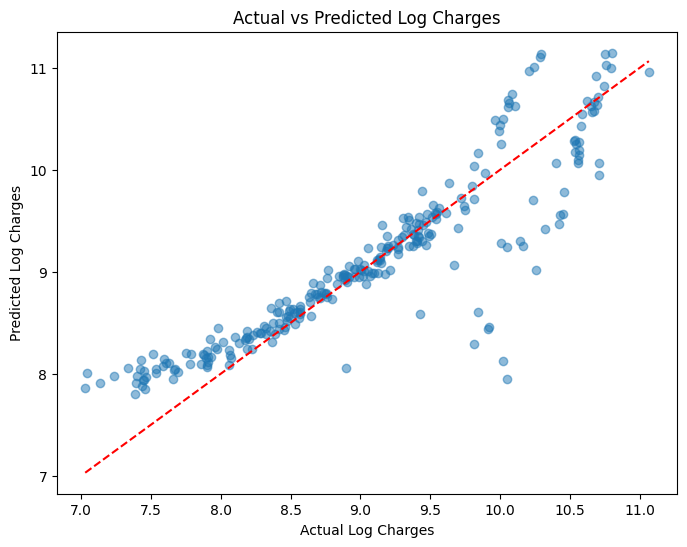

In [444]:
# make a scatter plot of model predicted charges vs actual charges
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Log Charges')
plt.ylabel('Predicted Log Charges')
plt.title('Actual vs Predicted Log Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

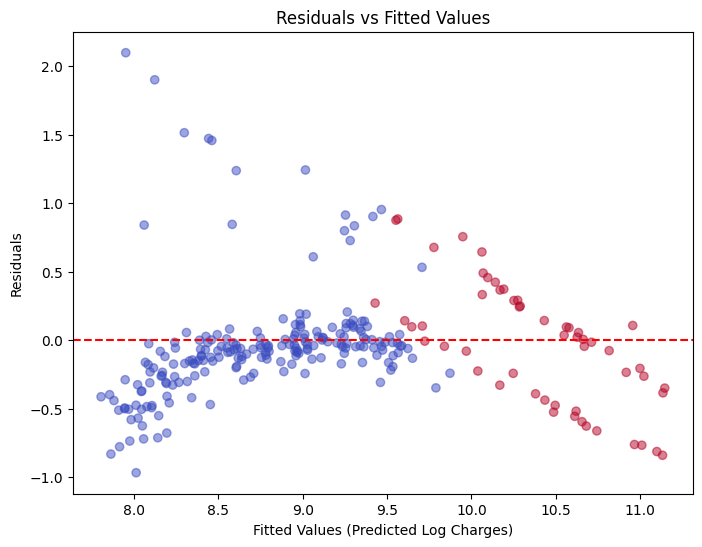

In [445]:
# plot residuals vs fitted values
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, c=data_df.loc[y_test.index, 'smoker'].map({'yes': 1, 'no': 0}), cmap='coolwarm')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Now that we have a baseline, we can explore more complex models and feature engineering techniques to improve performance.

## 5. Feature engineering and other approaches

###  5.1 Adding interaction terms and running Linear Regression again

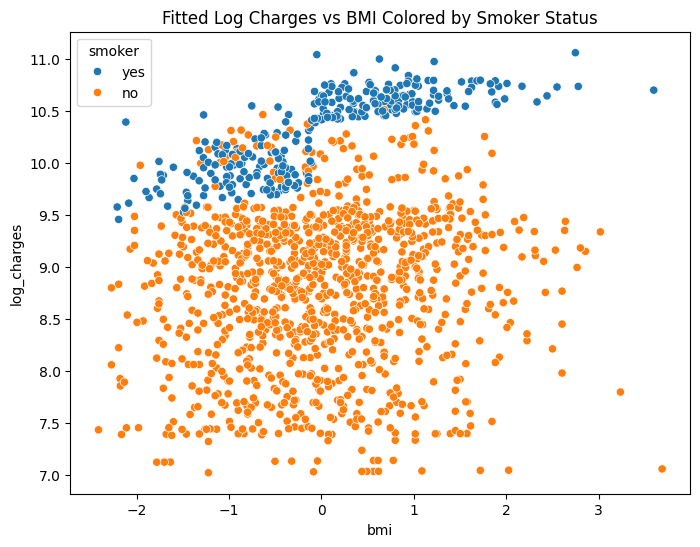

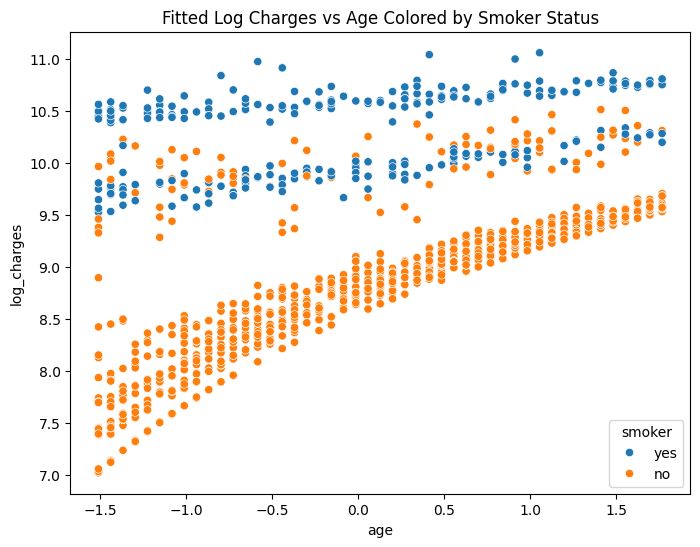

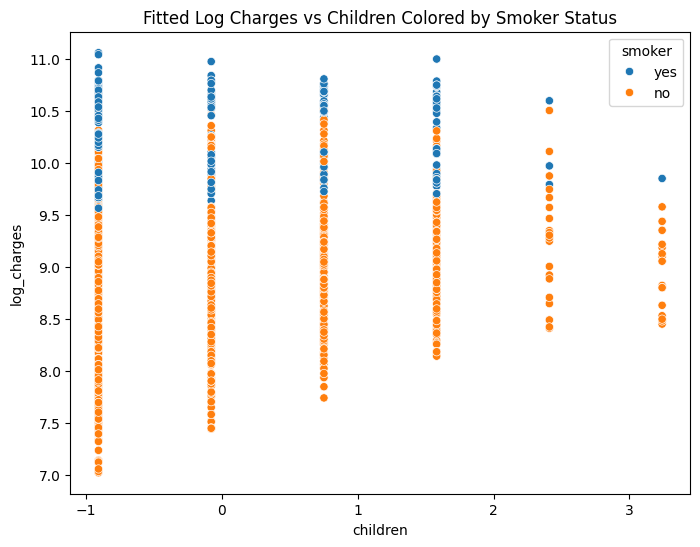

In [446]:
# Since smoker is the most important feature, plot a scatter plot of fitted charges vs each numerical feature colored by smoker status
plt.figure(figsize=(8, 6))
sns.scatterplot(x='bmi', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs BMI Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs Age Colored by Smoker Status')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='children', y='log_charges', hue='smoker', data=data_df)
plt.title('Fitted Log Charges vs Children Colored by Smoker Status')
plt.show()

From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, so considering a split in this group as a new feature and adding an interaction term between the new feature and smoker in the new model

In [447]:
# From plot of fitted charges vs bmi, we see a spike in charges for smokers with bmi>30, 
# so considering a split in this group as a new feature and 
# adding an interaction term between the new feature and smoker in the new model   
data_df['high_bmi'] = (data_df['bmi'] > 30).astype(int)
data_df['high_bmi_smoker_interaction'] = data_df['high_bmi'] * ((data_df['smoker'] == 'yes').astype(int))
data_df['high_bmi_bmi_interaction'] = data_df['high_bmi'] * data_df['bmi']
data_df['bmi_smoker_interaction'] = data_df['bmi'] * ((data_df['smoker'] == 'yes').astype(int))
data_df.drop(['high_bmi'], axis=1, inplace=True)
# Re-define features and target variable with the new feature
X = data_df.drop('log_charges', axis=1)
y = data_df['log_charges']
# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Use 10 fold cross-validation to evaluate the new model
model = LinearRegression()
mse_scores = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
print(f'Average MSE from 10-fold CV after adding high_bmi_smoker feature: {mse_scores.mean()}')
print(f'Average R2 from 10-fold CV after adding high_bmi_smoker feature: {r2_scores.mean()}')
# Fit the new model on the training data
model.fit(X_train, y_train)
# Predict on the test data
y_pred = model.predict(X_test)
# Evaluate the new model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MSE after adding high_bmi_smoker feature: {mse}')
print(f'Test R2 after adding high_bmi_smoker feature: {r2}')

Average MSE from 10-fold CV after adding high_bmi_smoker feature: 0.19128891710049967
Average R2 from 10-fold CV after adding high_bmi_smoker feature: 0.7670474471923583
Test MSE after adding high_bmi_smoker feature: 0.1645822236770192
Test R2 after adding high_bmi_smoker feature: 0.8169560889305182


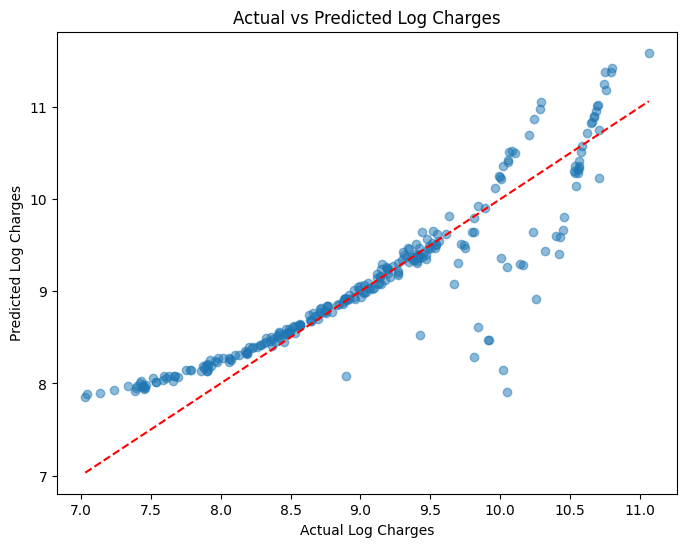

In [448]:
# make a scatter plot of model predicted charges vs actual charges
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Log Charges')
plt.ylabel('Predicted Log Charges')
plt.title('Actual vs Predicted Log Charges')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

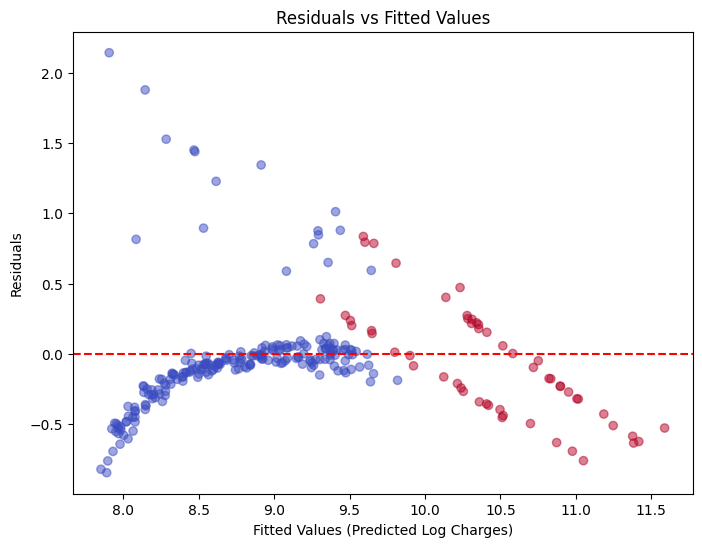

In [449]:
# plot residuals vs fitted values
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, c=data_df.loc[y_test.index, 'smoker'].map({'yes': 1, 'no': 0}), cmap='coolwarm')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

We have a better fit now with the inclusion of the new feature, our test R2 has gone up from 0.8047311493462986 to 0.8169560889305182

### 5.2 Random Forest with hyperparameter tuning

In [450]:
# Try using a Random Forest with hyperparameter tuning to see if we can improve the model performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
# Predict on the test data using the best Random Forest model
y_pred_rf = best_rf.predict(X_test)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Test MSE: {mse_rf}')
print(f'Random Forest Test R2: {r2_rf}')

Random Forest Test MSE: 0.13222294173512847
Random Forest Test R2: 0.852945209709853


### 5.3 LightGBM with hyperparameter tuning

In [451]:
# use LightGBM to see if we can improve the model performance further
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
# specify your configurations as a dict
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval)
# predict
y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# evaluate
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f'LightGBM Test MSE: {mse_lgb}')
print(f'LightGBM Test R2: {r2_lgb}')

LightGBM Test MSE: 0.14050581808699658
LightGBM Test R2: 0.8437332179863352


### 5.4 XGBoost with hyperparameter tuning

In [452]:
# Run XGBoost to see if we can improve the model performance further using GridSearchCV for hyperparameter tuning
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
# Predict on the test data using the best XGBoost model
y_pred_xgb = best_xgb.predict(X_test)
# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost Test MSE: {mse_xgb}')
print(f'XGBoost Test R2: {r2_xgb}')

XGBoost Test MSE: 0.12121945617424862
XGBoost Test R2: 0.8651829896320187


The XGBoost algorithm has the best R2 of all algorithms so far, looking for opportunities to improve the model further.

### 5.5 Exploring higher order interactions

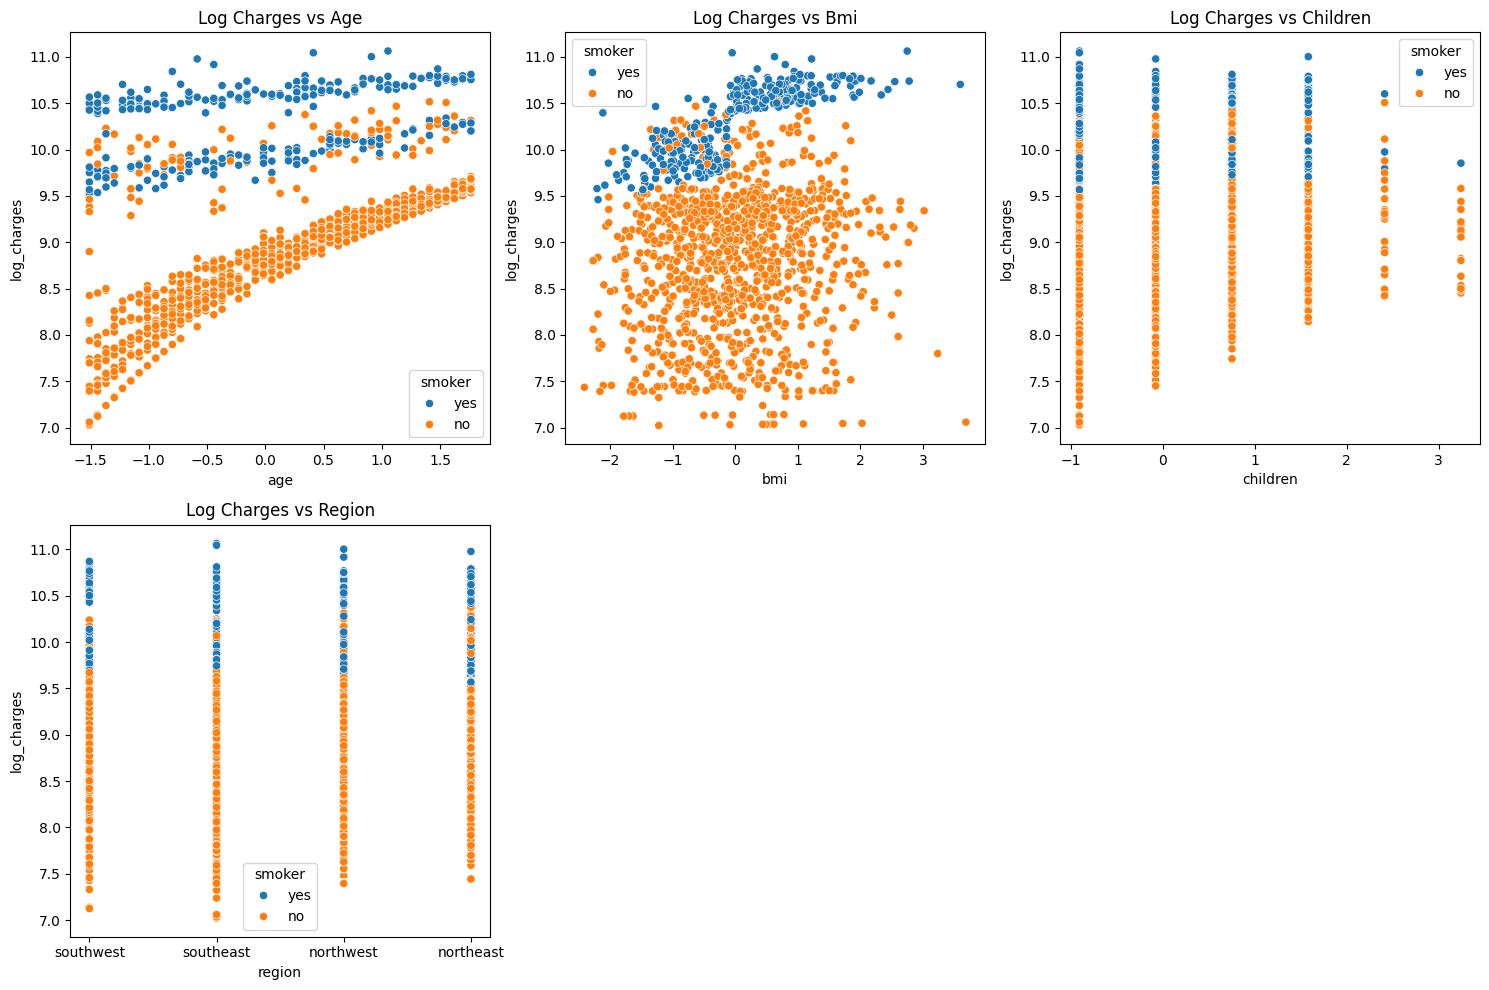

In [453]:
# create a grid of scatter plots of charges vs each of the input features to explore higher order interactions
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 10))

# Create a grid of scatter plots
features = ['age', 'bmi', 'children', 'region']
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=feature, y='log_charges', data=data_df, hue='smoker')
    plt.title(f'Log Charges vs {feature.capitalize()}')

plt.tight_layout()
plt.show()

### 5.6 Splitting data as smoker and non-smoker, fitting separate models

In [454]:
# Split the data into smoker and non-smoker groups and analyze the model performance separately
smoker_df = data_df[data_df['smoker'] == 'yes']
non_smoker_df = data_df[data_df['smoker'] == 'no']
# Define features and target variable for smoker group
X_smoker = smoker_df.drop('log_charges', axis=1)
y_smoker = smoker_df['log_charges']
# One-hot encode categorical variables
X_smoker = pd.get_dummies(X_smoker, drop_first=True)
# Use train-test split
X_train_smoker, X_test_smoker, y_train_smoker, y_test_smoker = train_test_split(X_smoker, y_smoker, test_size=0.2, random_state=42)


# Use hyperparameter tuning to find the best XGBoost model for smoker group
xgb_model_smoker = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_smoker = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_smoker = GridSearchCV(estimator=xgb_model_smoker, param_grid=param_grid_smoker, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_smoker.fit(X_train_smoker, y_train_smoker)
best_xgb_smoker = grid_search_xgb_smoker.best_estimator_
# Predict on the test data using the best XGBoost model for smoker group
y_pred_xgb_smoker = best_xgb_smoker.predict(X_test_smoker)
# Evaluate the XGBoost model for smoker group
mse_xgb_smoker = mean_squared_error(y_test_smoker, y_pred_xgb_smoker)
r2_xgb_smoker = r2_score(y_test_smoker, y_pred_xgb_smoker)
print(f'XGBoost Test MSE for Smoker Group: {mse_xgb_smoker}')
print(f'XGBoost Test R2 for Smoker Group: {r2_xgb_smoker}') 

XGBoost Test MSE for Smoker Group: 0.011738979679792524
XGBoost Test R2 for Smoker Group: 0.9265353208835145


In [455]:
# do the same for non-smoker group
# Define features and target variable for non-smoker group
X_non_smoker = non_smoker_df.drop('log_charges', axis=1)
y_non_smoker = non_smoker_df['log_charges']
# One-hot encode categorical variables
X_non_smoker = pd.get_dummies(X_non_smoker, drop_first=True)
# Use train-test split
X_train_non_smoker, X_test_non_smoker, y_train_non_smoker, y_test_non_smoker = train_test_split(X_non_smoker, y_non_smoker, test_size=0.2, random_state=42)
# Use hyperparameter tuning to find the best XGBoost model for non-smoker group
xgb_model_non_smoker = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid_non_smoker = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
grid_search_xgb_non_smoker = GridSearchCV(estimator=xgb_model_non_smoker, param_grid=param_grid_non_smoker, cv=5, scoring='r2', n_jobs=-1)
grid_search_xgb_non_smoker.fit(X_train_non_smoker, y_train_non_smoker)
best_xgb_non_smoker = grid_search_xgb_non_smoker.best_estimator_
# Predict on the test data using the best XGBoost model for non-smoker group
y_pred_xgb_non_smoker = best_xgb_non_smoker.predict(X_test_non_smoker)
# Evaluate the XGBoost model for non-smoker group
mse_xgb_non_smoker = mean_squared_error(y_test_non_smoker, y_pred_xgb_non_smoker)
r2_xgb_non_smoker = r2_score(y_test_non_smoker, y_pred_xgb_non_smoker)
print(f'XGBoost Test MSE for Non-Smoker Group: {mse_xgb_non_smoker}')
print(f'XGBoost Test R2 for Non-Smoker Group: {r2_xgb_non_smoker}')

XGBoost Test MSE for Non-Smoker Group: 0.14322486334544013
XGBoost Test R2 for Non-Smoker Group: 0.7459074062151126


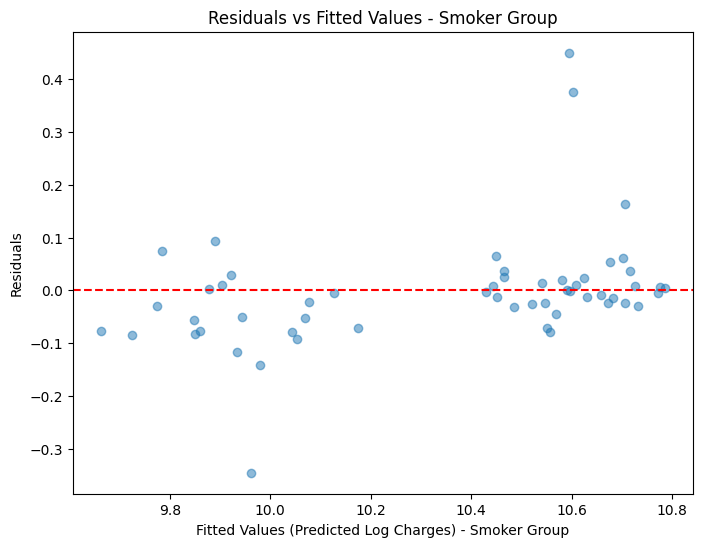

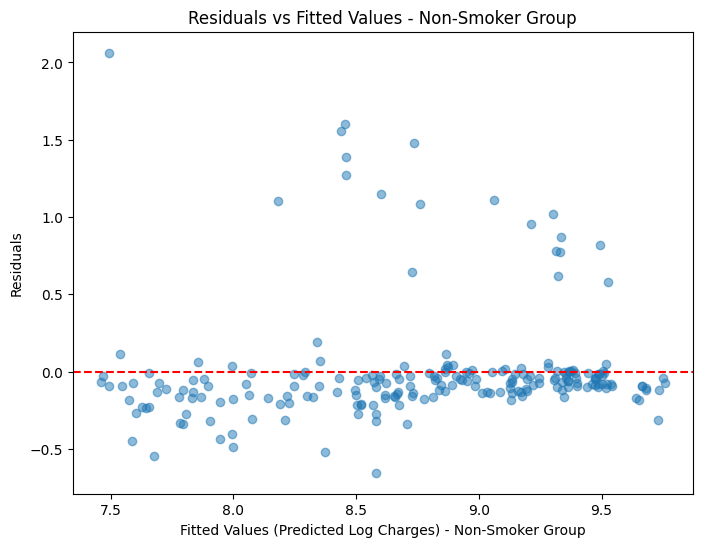

In [463]:
# plot the residuals vs fitted values for smoker and non-smoker groups separately
# smoker group
residuals_smoker = y_test_smoker - y_pred_xgb_smoker
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb_smoker, residuals_smoker, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges) - Smoker Group')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values - Smoker Group')
plt.show()
# non-smoker group
residuals_non_smoker = y_test_non_smoker - y_pred_xgb_non_smoker
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_xgb_non_smoker, residuals_non_smoker, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Predicted Log Charges) - Non-Smoker Group')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values - Non-Smoker Group')
plt.show()

In [465]:
# Exploring splines given the curvature seen in age vs log_charges plot for non-smokers, identify the best configuration using GridSearchCV
# keep the other features in the dataset as is for this analysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV    
spline_transformer = SplineTransformer(degree=3, n_knots=5)
pipeline = Pipeline([
    ('spline', spline_transformer),
    ('model', LinearRegression())
])
param_grid = {
    'spline__n_knots': [3, 5, 7],
    'spline__degree': [2, 3, 4]
}
grid_search_spline = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
X_age = X_train_non_smoker[['age']]
y_log_charges = y_train_non_smoker
# convert categorical variables to dummy variables
X = X_train_non_smoker.drop(columns=['age'])
X = pd.get_dummies(X, drop_first=True)
X['age'] = X_age
grid_search_spline.fit(X, y_log_charges)
best_spline_model = grid_search_spline.best_estimator_
print(f'Best Spline Parameters: {grid_search_spline.best_params_}')
# Predict using the best spline model
y_spline_pred = best_spline_model.predict(X)
# Evaluate the spline model
mse_spline = mean_squared_error(y_log_charges, y_spline_pred)
r2_spline = r2_score(y_log_charges, y_spline_pred)
print(f'Spline Model MSE: {mse_spline}')
print(f'Spline Model R2: {r2_spline}')

Best Spline Parameters: {'spline__degree': 2, 'spline__n_knots': 3}
Spline Model MSE: 0.16848540415584548
Spline Model R2: 0.6940052065654532


TODO continue XGBoost on the spline for the non-smoker data